# Feature Selection

In [72]:
import csv
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from preprocessing import preprocess

sns.set()

In [73]:
# squash probabilities
def squash(yard_cdf, yard_remaining):
    squash_cdf = yard_cdf.copy()
    squash_cdf[199-(100 - yard_remaining):] = 1
    squash_cdf[0:yard_remaining-1] = 0 
    return squash_cdf

## Load data

In [74]:
filename = 'train.csv' 
df = pd.read_csv(filename)
df.head()

/home/bradley/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW


## Split data

In [75]:
# Downsample, keep entries where player is rusher 
df = df[df['NflIdRusher']==df['NflId']]
df.reset_index(drop=True, inplace=True)

train, dev = train_test_split(df, test_size=0.3, random_state=1, shuffle=True)
print(train.shape)
print(dev.shape)

(16219, 49)
(6952, 49)


 # PreProcess

In [76]:
train, tables = preprocess(train)
dev, tables = preprocess(dev, tables)
train.head()
dev.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,WindSpeed,WindDirection,DefenseTeam,YardsAvgOffense,YardsAvgDefense,YardsRemaining,Carries,RusherMeanYards,RusherMaxYards,RusherMinYards
0,2017111907,20171119070499,home,30.27,28.56,3.74,1.71,0.41,14.29,113.39,...,6,W,BUF,4.443203,4.426667,75.0,329.0,4.322188,87.0,-4.0
1,2017102906,20171029063422,home,27.79,33.27,5.46,0.33,0.51,222.48,325.48,...,12,SE,SF,4.335185,4.058099,12.0,222.0,3.815315,68.0,-7.0
2,2018112503,20181125031651,away,30.70,22.33,4.64,2.94,0.45,272.10,251.62,...,4,S,CIN,4.452747,4.315881,16.0,134.0,5.537313,92.0,-5.0
3,2018101412,20181014120662,home,19.15,28.65,4.19,1.99,0.41,256.20,249.31,...,Calm,NaN,KC,4.500000,4.602210,4.0,149.0,4.382550,31.0,-4.0
4,2018112509,20181125090940,away,47.84,25.86,4.71,3.29,0.46,265.69,285.56,...,7,North,DEN,4.261224,4.001908,33.0,179.0,4.653631,30.0,-4.0


# Feature Selection

In [77]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

In [78]:
# # Tree-based feature selection¶
# X, y = df[["YardsRemaining", "DefendersInTheBox", "A"]], df.Yards
# clf = ExtraTreesClassifier(n_estimators=50)
# clf = clf.fit(X, y)
# clf.feature_importances_  
# model = SelectFromModel(clf, prefit=True)
# tree_features = model.transform(X)
# print(clf.feature_importances_)

# # K-best feature selection
# k_best_features = SelectKBest(chi2, k=2).fit_transform(X, y)
# print(k_best_features)

In [92]:
# Model Fitting 
# create a label encoder since not all -99:99 yards will appear 
features = ['Distance','Down','DefendersInTheBox','RusherMeanYards']

le = preprocessing.LabelEncoder()
le.fit(train['Yards'])

# Fit the model  
# clf = LogisticRegression(C = .2, max_iter = 100,solver = 'newton-cg',multi_class='multinomial',verbose=True)
clf = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=0, min_samples_split=20, min_samples_leaf=10)

clf.fit(train[features], le.transform(train['Yards']))

# Determine Model Cost 
def predsToPMF(preds):
    pmfs = np.zeros((preds.shape[0],199))
    for i in range(0, preds.shape[1]):
        pmfs[:,int(le.inverse_transform([i]))+99] = preds[:,i]
    return pmfs 

preds = clf.predict_proba(dev[features])
preds_pmfs = predsToPMF(preds)
preds_cdfs = np.cumsum(preds_pmfs, axis=1)

all_loss = []
i = 0
for index, row in dev.iterrows():
    preds_cdfs[i,:] = squash(preds_cdfs[i,:], int(row['YardsRemaining']))
    true_cdf = np.zeros(199)
    true_cdf[99+row['Yards']:] = 1
    loss = 1/199 * np.sum((preds_cdfs[i,:]-true_cdf)**2)
    all_loss.append(loss)
    i += 1 
cost = np.average(all_loss)
print("Cost: {}".format(cost))

Cost: 0.01392228498120229


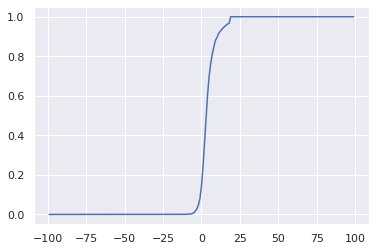

In [91]:
plt.plot(np.arange(-99, 100), pred_cdf)